In [1]:
%cd ..

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

In [3]:
k1 = pd.read_table("outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep4-gRNA1/train_history.tsv")
k2 = pd.read_table("outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep5-gRNA2/train_history.tsv")

In [4]:
# utils functions
def parse_arc_str(arc):
    rates = {}
    for i, a in enumerate(arc.split('|')):
        ele = a.split('-')
        #rates.append([int(ele[0]), int(ele[1]), int(ele[2].strip('k'))])
        rates[('k%i'%i, 'start')] = int(ele[0])
        rates[('k%i'%i, 'end')] = int(ele[1])
        rates[('k%i'%i, 'kernel')] = int(ele[2].strip('k'))
    return rates

def get_post_dist(df, top_cut=0.05):
    if type(top_cut) is float:
         top_cut = int(df.shape[0]*top_cut)
    a = df.sort_values('test_reward', ascending=False).head(top_cut)
    rates = pd.DataFrame(columns=[['k%i'%i for i in range(7) for _ in range(3)], ['start', 'end', 'kernel']*7] )
    for arc in a['arc']:
        r = parse_arc_str(arc)
        rates = rates.append(r, ignore_index=True)
    return rates

def kl_divergence(a, b):
    return sum(a[i] * np.log(a[i]/b[i]) for i in a)

def r_kl_div(a, b):
    """reciprocal kl-divergence between two probability distributions"""
    return (kl_divergence(a,b) + kl_divergence(b,a) ) / 2

def convert_two_counters(a, b, pseudo_cnt=1):
    union_ks = set(list(a.keys()) + list(b.keys()))
    a_sum = sum(a.values()) + pseudo_cnt*len(union_ks)
    b_sum = sum(a.values()) + pseudo_cnt*len(union_ks)
    a_ = { i:(a[i]+pseudo_cnt)/a_sum if i in a else pseudo_cnt/a_sum for i in union_ks}
    b_ = { i:(b[i]+pseudo_cnt)/b_sum if i in b else pseudo_cnt/b_sum for i in union_ks}
    return a_, b_

In [5]:
import warnings
warnings.simplefilter("ignore")
model1 = get_post_dist(k1, top_cut=100)
model2 = get_post_dist(k2, top_cut=100)

In [6]:
model1['model'] = 'gRNA1'
model2['model'] = 'gRNA2'
model = pd.concat([model1, model2])
model.reset_index(inplace=True)

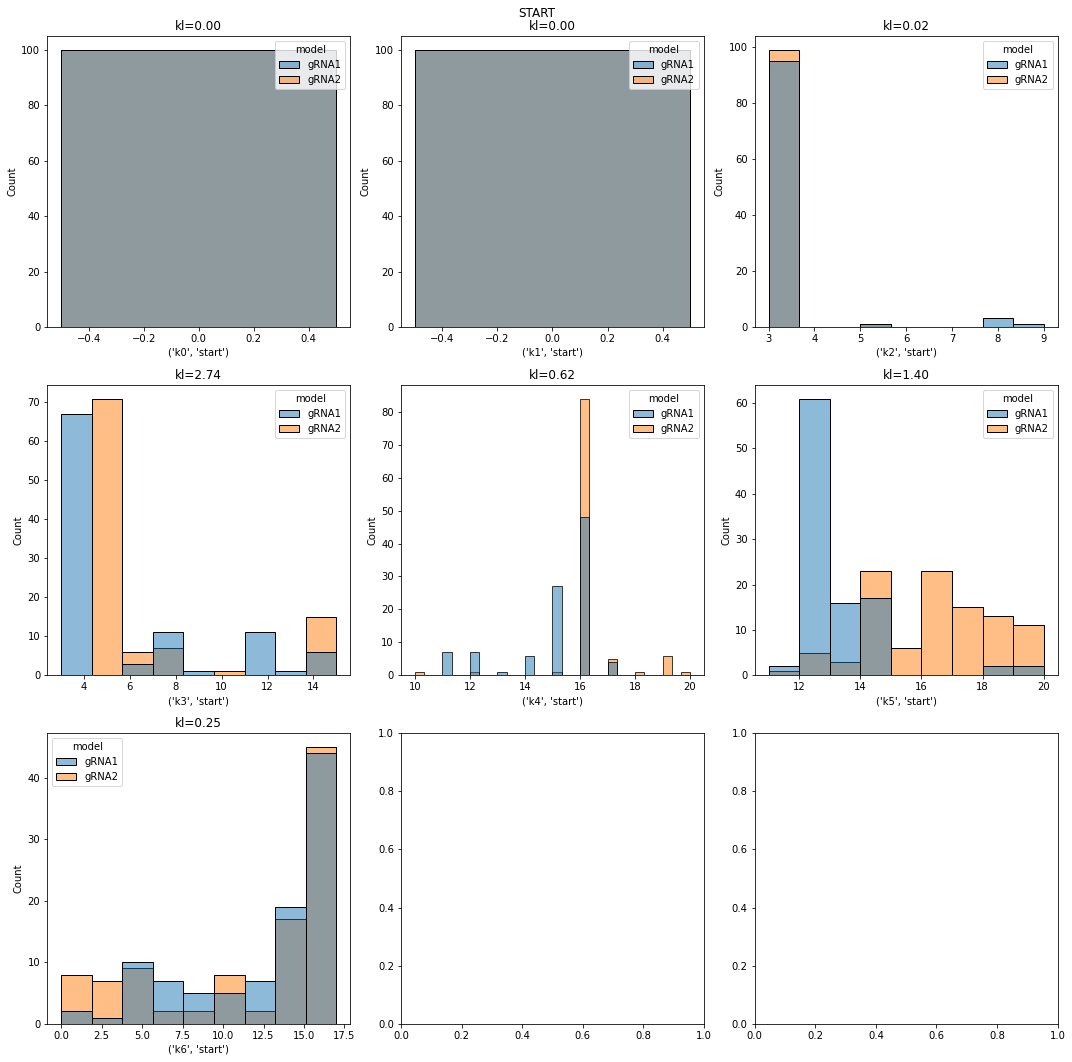

In [7]:
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for k in range(7):
    ax = axs[k]
    sns.histplot(x=('k%i'%k, 'start'), hue='model', data=model, ax=ax)
    a=Counter(model1['k%i'%k]['start'])
    b=Counter(model2['k%i'%k]['start'])
    a,b=convert_two_counters(a,b)
    ax.set_title("kl=%.2f" % r_kl_div(a,b))
    #ax.legend().remove()
fig.suptitle('START')
fig.tight_layout()

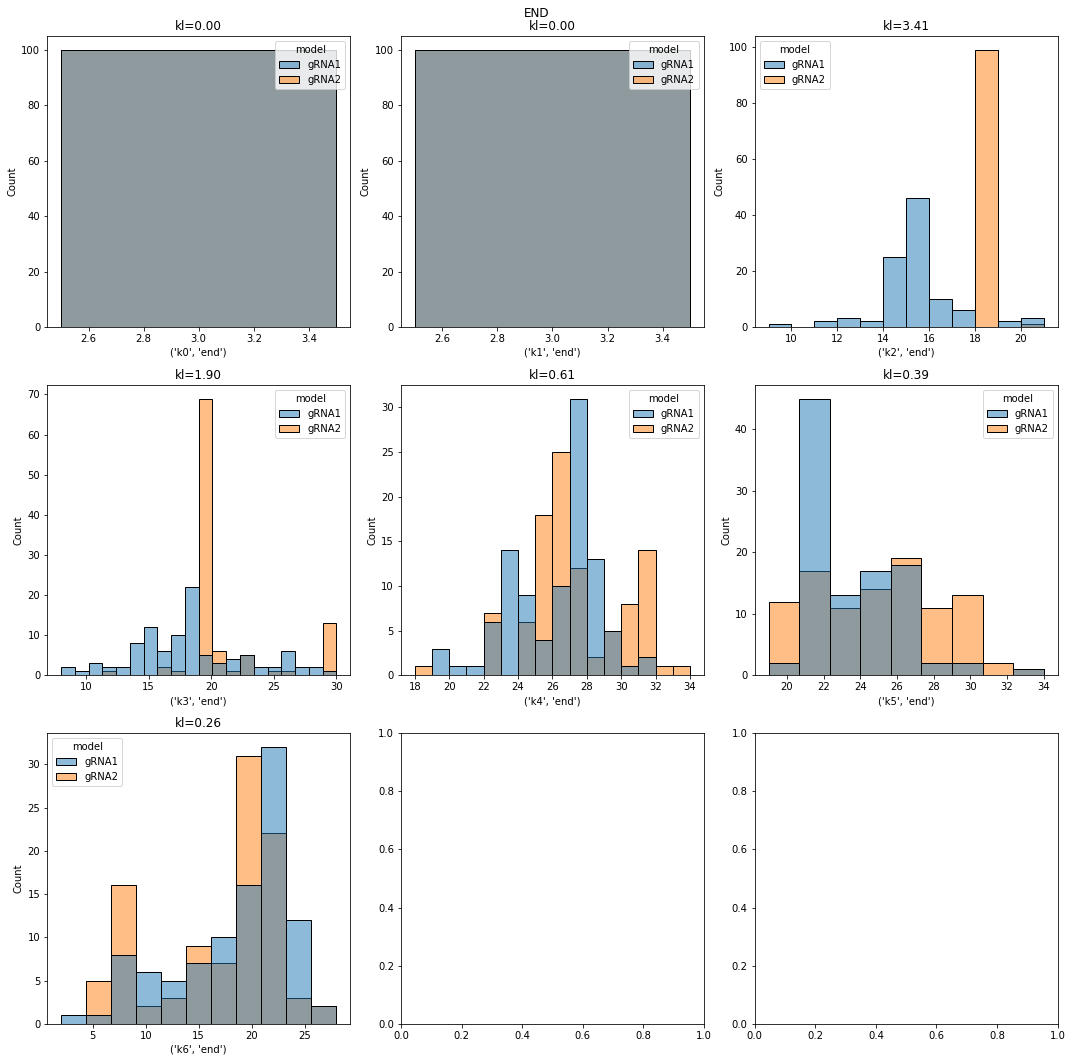

In [8]:
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for k in range(7):
    ax = axs[k]
    sns.histplot(x=('k%i'%k, 'end'), hue='model', data=model, ax=ax)
    a=Counter(model1['k%i'%k]['end'])
    b=Counter(model2['k%i'%k]['end'])
    a,b=convert_two_counters(a,b)
    ax.set_title("kl=%.2f" % r_kl_div(a,b))
    #ax.legend().remove()
fig.suptitle('END')
fig.tight_layout()

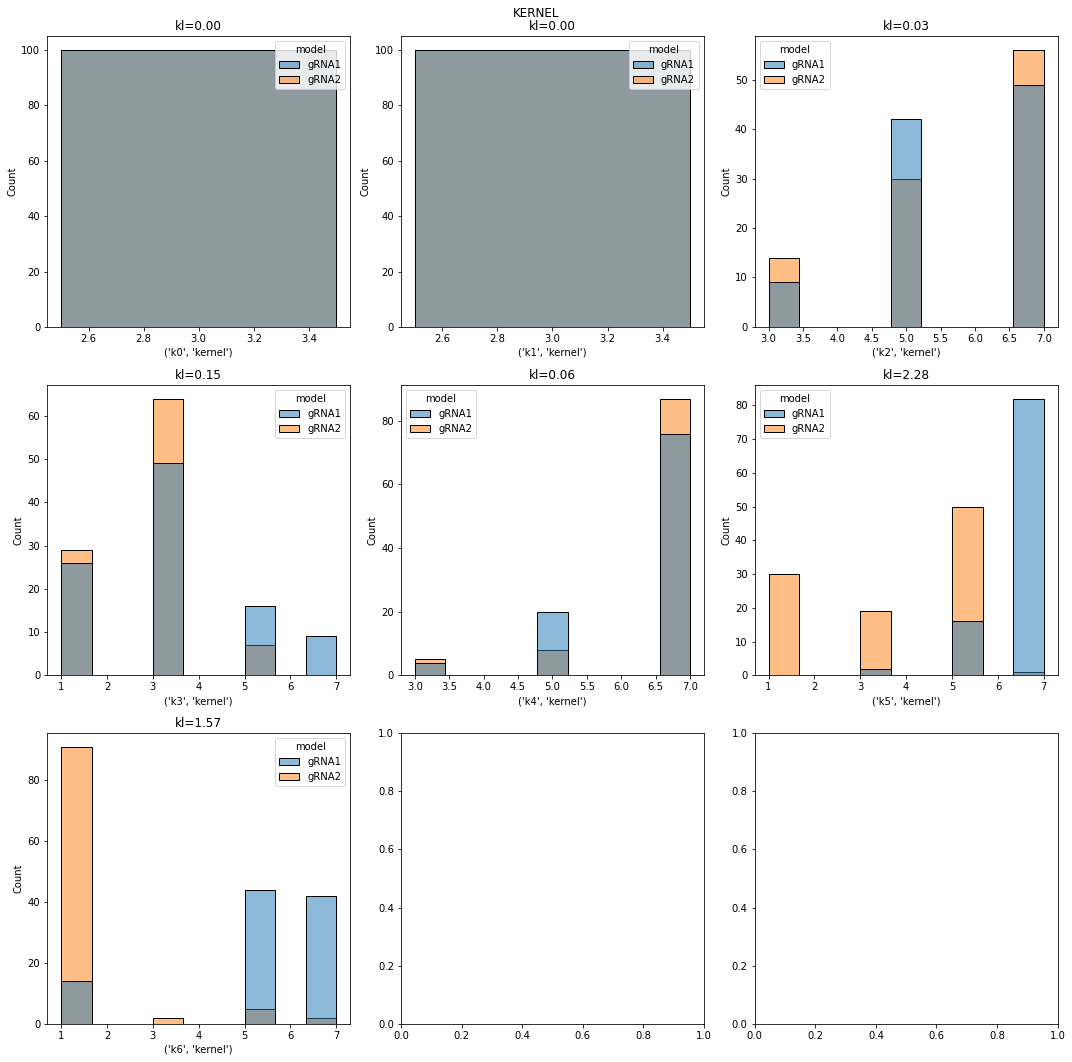

In [9]:
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for k in range(7):
    ax = axs[k]
    sns.histplot(x=('k%i'%k, 'kernel'), hue='model', data=model, ax=ax)
    a=Counter(model1['k%i'%k]['kernel'])
    b=Counter(model2['k%i'%k]['kernel'])
    a,b=convert_two_counters(a,b)
    ax.set_title("kl=%.2f" % r_kl_div(a,b))
    #ax.legend().remove()
fig.suptitle('KERNEL')
fig.tight_layout()

In [10]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Aug 30 2022

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.22.0

matplotlib: 3.4.3
seaborn   : 0.11.1
numpy     : 1.21.6
pandas    : 1.3.5

Watermark: 2.3.1

